In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow import keras
from IPython.display import display 
from PIL import Image
train = pd.read_csv('/home/xiaodaidai/Documents/ml_lhy/assignment3/train.csv')
test = pd.read_csv('/home/xiaodaidai/Documents/ml_lhy/assignment3/test.csv')

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns',1000)


In [2]:
train.values.shape

(28709, 2)

In [5]:
# np.asarray(train['feature'].values[i].split(), dtype = int).reshape(48,48)

In [6]:
# train_all = np.zeros((train.values.shape[0],48,48,1))
# for i in range(train.values.shape[0]):
#     train_all[i,:,:,:] = np.asarray(train['feature'].values[i].split(), dtype = int).reshape(48,48,1)


In [7]:
train_all = np.asarray([np.asarray(x.split(), dtype = int).reshape(48,48,1) for x in train['feature'].values])
train_all.shape

(28709, 48, 48, 1)

In [8]:
train_y_all = np.asarray(train['label'].values.reshape((train.values.shape[0],1)),dtype = int)
print(train_y_all.shape)
print(train_all.shape)

(28709, 1)
(28709, 48, 48, 1)


In [9]:
pm = np.random.permutation(train_y_all.shape[0])
t = int(len(pm)*0.7)



In [10]:
# zero-mean
train_all_norm = train_all - int(train_all.mean())

In [11]:
train_x = train_all[pm[0:t],:,:]
train_y = train_y_all[pm[0:t],:]
test_x = train_all[pm[t:len(pm)],:,:]
test_y = train_y_all[pm[t:len(pm)],:]
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(20096, 48, 48, 1) (20096, 1) (8613, 48, 48, 1) (8613, 1)


In [12]:
print(train_x.mean(),test_x.mean())
print(train_x.max(),train_x.min())

129.45622420800296 129.51660658911916
255 0


In [13]:
# display image

# plt.imshow(np.array(train_x[90,:,:,:].reshape(48,48)), cmap=cm.gray)

In [19]:
# test
datagen_shift = keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-8,8])
datagen_rotate = keras.preprocessing.image.ImageDataGenerator(rotation_range=30)
datagen_bright = keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.2,1.6])
datagen_zoom = keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5,1.5])
it_shift = datagen_shift.flow(train_x, train_y,batch_size = 20)
it_rotate = datagen_rotate.flow(train_x, train_y,batch_size = 20)
it_bright = datagen_bright.flow(train_x, train_y,batch_size = 20)
it_zoom = datagen_zoom.flow(train_x, train_y,batch_size = 20)
batch_shift = it_shift.next()
batch_rotate = it_rotate.next()
batch_bright = it_bright.next()
batch_zoom = it_zoom.next()
# print(len(batch)) #1st dim is for x, 2nd dim is for y
# print(len(batch[0])) #list of images, batch_size determines how many images are created
# print(len(batch[0][0]))
# print(len(batch[0][0][0]))
# print(len(batch[0][0][0][0]))

plt.imshow(np.array(batch_shift[0][19].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


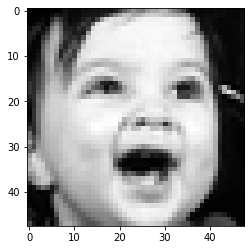

In [23]:
plt.imshow(np.array(batch_bright[0][6].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


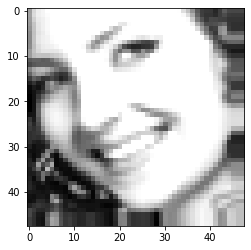

In [36]:
datagen_all = keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               brightness_range=[0.5, 1.5])
it_all = datagen_all.flow(train_x,train_y,batch_size = train_x.shape[0])
batch_all = it_all.next()
plt.imshow(np.array(batch_all[0][0].reshape(48,48)), cmap=cm.gray) #batch[0][0] is the first image in the created batch


In [47]:
epoch = 30
i = 0
train_x_aug = batch_all[0]
train_y_aug = batch_all[1]
while i < epoch:
    i += 1
    batch_all = it_all.next()
    train_x_aug = np.append(train_x_aug, batch_all[0], axis = 0)
    train_y_aug = np.append(train_y_aug, batch_all[1], axis = 0)
train_x_aug.shape

(80384, 48, 48, 1)

In [48]:
train_y_aug.shape


(80384, 1)

In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),  input_shape=(48, 48, 1)
#                         ,activation = 'relu'
                        ,kernel_initializer='glorot_uniform'
                       ))
# model.add(layers.LeakyReLU())
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3)
#                         ,activation = 'relu'
                       ))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3)
#                         , activation='relu'
                       ))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128
#                        ,activation = 'relu'
                       , kernel_regularizer=keras.regularizers.l1(0.01)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# model.add(layers.Dropout(0.5))
# model.add(layers.LeakyReLU())
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(7, activation='softmax'
#                        , kernel_regularizer=keras.regularizers.l1(0.01)
                      ))

W1013 22:28:45.570988 140556424111936 deprecation.py:506] From /home/xiaodaidai/virtualenv/kaggle/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 21, 21, 64)        0

In [ ]:
adam = keras.optimizers.Adam(learning_rate=1, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x_aug, train_y_aug, batch_size=1024,
                    epochs=5)

Epoch 1/5
80384/80384 [==============================] - 186s 2ms/sample - loss: 19.6420 - acc: 0.2649
Epoch 2/5
80384/80384 [==============================] - 190s 2ms/sample - loss: 3.2980 - acc: 0.3387
Epoch 3/5
80384/80384 [==============================] - 185s 2ms/sample - loss: 2.9825 - acc: 0.3666
Epoch 4/5
26624/80384 [========>.....................] - ETA: 2:11 - loss: 2.9144 - acc: 0.3788

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)